In [2]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
ma_df = pd.read_csv('food_insecuity_mass_census_2015')

ma_df.head()

,seq_id,ct10_id,municipal,nhd,county,years,pop,fi_p,unemp_p,pov_p,...,homeown_p,fi_num,snapbelowp,snapabovep,cost_index,short_week,short_year,weightcost,meal_gap,omad_goal
0,1,25025110601,Boston,West Roxbury,Suffolk,2015,2946.0,10.7,9.8,9.6,...,78.2,320.0,82.2,17.8,1.212,21.07,201000.0,3.56,56600.0,18900.0
1,2,25025130100,Boston,West Roxbury,Suffolk,2015,6517.0,6.1,2.9,3.3,...,74.2,400.0,82.2,17.8,1.212,21.07,254000.0,3.56,71400.0,23800.0
2,3,25025130200,Boston,West Roxbury,Suffolk,2015,5008.0,7.9,2.9,8.9,...,62.3,400.0,82.2,17.8,1.212,21.07,253000.0,3.56,71000.0,23700.0
3,4,25025130300,Boston,West Roxbury,Suffolk,2015,4680.0,6.4,7.3,0.2,...,77.8,300.0,82.2,17.8,1.212,21.07,191000.0,3.56,53800.0,17900.0
4,5,25025130402,Boston,West Roxbury,Suffolk,2015,4908.0,7.8,4.7,7.0,...,74.2,380.0,82.2,17.8,1.212,21.07,245000.0,3.56,68700.0,22900.0


In [4]:
#Change column names for readability
ma_df = ma_df.rename(columns={"ct10_id": "Census Tract", "nhd": "Neighborhood", "county": "County", "pop": "Population", "unemp_p": "Unemployment Rate", "pov_p": "Poverty Rate", "fi_p": "Food Insecurity Rate", "mhi": "Median Household Income", "aa_p": "Percent Black", "lat_p": "Percent Latinx", "homeown_p": "Percent Homeowning", "fi_num": "Number Food Insecure", "snapbelowp": "Percent Below SNAP Threshold", "snapabovep": "Percent Above SNAP Threshold", "cost_index": "Cost of Food Index"})

#Drop columns unimportant to the study
ma_df = ma_df.drop(columns =["seq_id", "municipal", "years", "short_week", "short_year", "weightcost", "meal_gap", "omad_goal"])

#Drop rows which are not Suffolk County
ma_df = ma_df.drop(ma_df[ma_df['County'] != 'Suffolk'].index)

#Drop NaN values (missing values)
ma_df = ma_df.dropna()

# Confirm the shape of the DataFrame after dropping and resetting indices
print("Shape of ma_df after dropping missing values and resetting indices:", ma_df.shape)

Shape of ma_df after dropping missing values and resetting indices: (169, 15)


In [5]:
ma_df.style

,Census Tract,Neighborhood,County,Population,Food Insecurity Rate,Unemployment Rate,Poverty Rate,Median Household Income,Percent Black,Percent Latinx,Percent Homeowning,Number Food Insecure,Percent Below SNAP Threshold,Percent Above SNAP Threshold,Cost of Food Index
0,25025110601,West Roxbury,Suffolk,2946.000000,10.700000,9.800000,9.600000,87426.000000,5.000000,4.700000,78.200000,320.000000,82.200000,17.800000,1.212000
1,25025130100,West Roxbury,Suffolk,6517.000000,6.100000,2.900000,3.300000,79844.000000,1.700000,3.700000,74.200000,400.000000,82.200000,17.800000,1.212000
2,25025130200,West Roxbury,Suffolk,5008.000000,7.900000,2.900000,8.900000,100952.000000,2.000000,5.100000,62.300000,400.000000,82.200000,17.800000,1.212000
3,25025130300,West Roxbury,Suffolk,4680.000000,6.400000,7.300000,0.200000,108472.000000,2.300000,5.800000,77.800000,300.000000,82.200000,17.800000,1.212000
4,25025130402,West Roxbury,Suffolk,4908.000000,7.800000,4.700000,7.000000,66394.000000,2.000000,5.800000,74.200000,380.000000,82.200000,17.800000,1.212000
5,25025130404,West Roxbury,Suffolk,3337.000000,7.000000,4.700000,3.600000,72976.000000,8.000000,16.500000,59.300000,230.000000,82.200000,17.800000,1.212000
6,25025130406,West Roxbury,Suffolk,5399.000000,18.800000,5.700000,18.300000,41981.000000,48.400000,21.800000,25.200000,1020.000000,82.200000,17.800000,1.212000
7,25025020301,West End,Suffolk,2371.000000,13.500000,3.000000,13.000000,114643.000000,3.100000,5.300000,15.600000,320.000000,82.200000,17.800000,1.212000
8,25025020303,West End,Suffolk,3574.000000,16.800000,10.200000,19.800000,81607.000000,9.200000,16.400000,27.200000,600.000000,82.200000,17.800000,1.212000
9,25025070402,South End,Suffolk,1700.000000,30.500000,13.900000,42.700000,15848.000000,10.400000,4.600000,0.000000,520.000000,82.200000,17.800000,1.212000


In [6]:
ma_df.columns

Index(['Census Tract', 'Neighborhood', 'County', 'Population',
       'Food Insecurity Rate', 'Unemployment Rate', 'Poverty Rate',
       'Median Household Income', 'Percent Black', 'Percent Latinx',
       'Percent Homeowning', 'Number Food Insecure',
       'Percent Below SNAP Threshold', 'Percent Above SNAP Threshold',
       'Cost of Food Index'],
      dtype='object')

In [7]:
ma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 1087
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Census Tract                  169 non-null    int64  
 1   Neighborhood                  169 non-null    object 
 2   County                        169 non-null    object 
 3   Population                    169 non-null    float64
 4   Food Insecurity Rate          169 non-null    float64
 5   Unemployment Rate             169 non-null    float64
 6   Poverty Rate                  169 non-null    float64
 7   Median Household Income       169 non-null    float64
 8   Percent Black                 169 non-null    float64
 9   Percent Latinx                169 non-null    float64
 10  Percent Homeowning            169 non-null    float64
 11  Number Food Insecure          169 non-null    float64
 12  Percent Below SNAP Threshold  169 non-null    float64
 13  Perc

In [8]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Setting y variable to the target variable Food Insecurity Rate
y = ma_df['Food Insecurity Rate']

# Define bins based on value ranges
bins = [0, 10, 20, 30, 40, 50]  # Bins fit the variance of food insecurity in the dataset
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Create categorical labels using bins
y_categorical = pd.cut(y, bins=bins, labels=labels)

# Drop rows with missing values after binning
ma_df_binned = ma_df.dropna(subset=['Food Insecurity Rate'])

# Drop unnecessary columns from X
X = ma_df_binned.drop(['Food Insecurity Rate', 'Number Food Insecure', 'County', 'Population', 'Neighborhood', 'Census Tract', 'Percent Above SNAP Threshold', 'Percent Below SNAP Threshold', 'Cost of Food Index'], axis=1)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y_categorical, test_size=0.5, random_state=4400)

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=4400)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search to find the best combination of parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_valid, y_valid)

# Get the best estimator and its parameters
best_params = grid_search.best_params_

# Make predictions using the best Random Forest classifier
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_valid, y_valid)
y_pred = best_rf.predict(X_train)

# Calculate accuracy of the best Random Forest classifier
accuracy = accuracy_score(y_train, y_pred)
print("Best Random Forest Accuracy:", accuracy)
print("Best Parameters:", best_params)


Best Random Forest Accuracy: 0.6785714285714286
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 50}


In [9]:
print(X)

      Unemployment Rate  Poverty Rate  Median Household Income  Percent Black  \
0                   9.8           9.6                  87426.0            5.0   
1                   2.9           3.3                  79844.0            1.7   
2                   2.9           8.9                 100952.0            2.0   
3                   7.3           0.2                 108472.0            2.3   
4                   4.7           7.0                  66394.0            2.0   
...                 ...           ...                      ...            ...   
164                 9.6          44.4                  29116.0           12.4   
165                 7.5          26.2                  48633.0            7.8   
166                 8.1          29.6                  38389.0            7.9   
167                 8.9          37.0                  32140.0            6.8   
1087               19.9          37.8                  29545.0           59.9   

      Percent Latinx  Perce

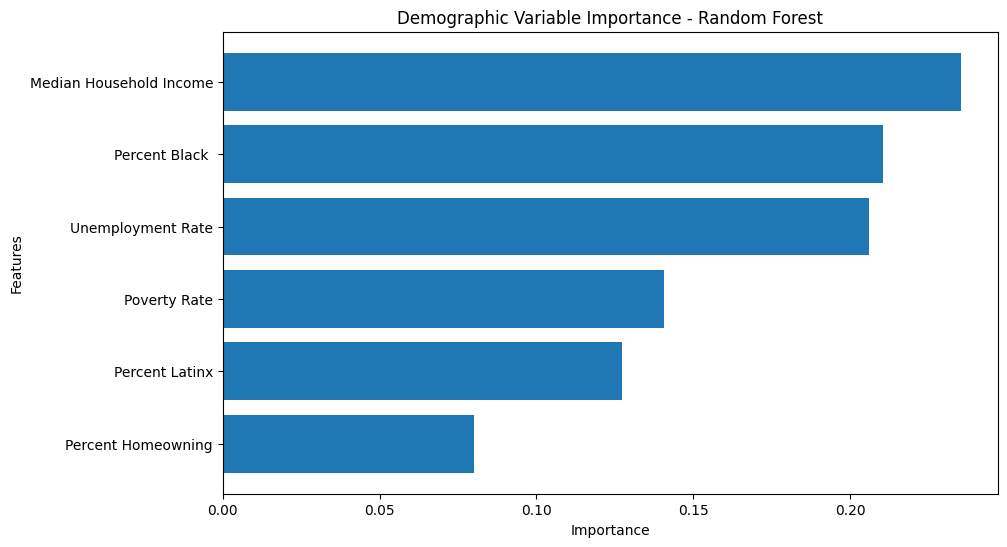

In [10]:
import numpy as np
# Plot the variable importance for Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)

feature_names = ['Unemployment Rate', 'Poverty Rate', 'Median Household Income',
       'Percent Black ', 'Percent Latinx', 'Percent Homeowning','Percent Below SNAP Threshold', 'Percent Above SNAP Threshold', 
       'Cost of Food Index']

plt.figure(figsize=(10, 6))
plt.title("Demographic Variable Importance - Random Forest")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()